### Importar librerías y series de datos

In [181]:
#importar datos y librerias
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy import special
#leer excel de datos y de dias especiales
general = pd.read_excel (r'C:\Users\Diana\PAP\Data\Data1.xlsx')
special_days= pd.read_excel (r'C:\Users\Diana\PAP\Data\Christmas.xlsx')
#convertir dias especiales a fechas en python
for column in special_days.columns:
    special_days[column] = pd.to_datetime(special_days[column])
general = general.set_index('fecha')

### Establecer las funciones a utilizar

In [182]:
def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    x=0
    data1_kron=data1[x:x+1]
    data2_kron=data2[x:x+1]
    Combinacion=np.kron(data1_kron,data2_kron)
    Combinacion=pd.DataFrame(Combinacion)
    for x in range(1,len(data1)):
        data1_kron=data1[x:x+1]
        data2_kron=data2[x:x+1]
        kron=np.kron(data1_kron,data2_kron)
        Kron=pd.DataFrame(kron)
        Combinacion=Combinacion.append(Kron)
    return Combinacion

In [183]:
def regresion_linear(X:'variables para regresion',y:'datos'):
    global model
    model.fit(X, y)
    coefficients=model.coef_
    return model.predict(X)

### Hacer variables dummies

In [184]:
onlyMWh=pd.DataFrame(general.MWh)
general['Month'] = general.index.month
general['Weekday_Name'] = general.index.weekday_name
dates=general.index
dummies = pd.get_dummies(general['Weekday_Name']).astype(int)
dummies2 = pd.get_dummies(general['Month']).astype(int)
Dum=pd.DataFrame(dummies.join(dummies2))
t=np.arange(0,len(onlyMWh))
Dum["t"]= np.arange(0,len(onlyMWh))
Dum["tiempo"]= np.arange(1,len(onlyMWh)+1)
Dum["ones"]=np.ones(len(t))
Dum= Dum.set_index('t')

In [185]:
Dum["Christmas"]=0
Dum["NewYear"]=0
Dum["Grito"]=0
Dum["Santo"]=0
ind=0 
for date in general.index:
    for date2 in special_days["Christmas"]:
        if date ==date2:
            Dum.iloc[ind,21]=1
    for date2 in special_days["NewYear"]:
        if date ==date2:
            Dum.iloc[ind,22]=1
    for date2 in special_days["Grito"]:
        if date ==date2:
            Dum.iloc[ind,23]=1
    for date2 in special_days["Santo"]:
        if date ==date2:
            Dum.iloc[ind,24]=1
    ind+=1
del Dum["Friday"]
Dum.drop(Dum.columns[[15]], axis=1,inplace=True)

### Observar descomposición

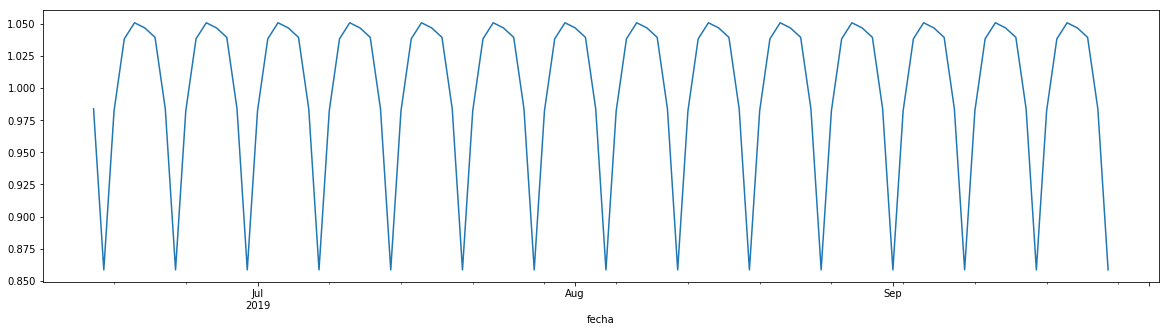

In [186]:
part=final=general.MWh.tail(100)
result=seasonal_decompose(part, model='multiplicative')
fig = result.seasonal.plot(figsize=(20,5))

Al ver la decomposición, se puede ver por la forma que fourier debe estblecerse en senos y cosenos absolutos, para que se parezca a la estacionalidad de la serie. Se agrega a las variables dummies esta estacionalidad semanal, que parece ser fundamental en los datos

### Detectar efecto de las variables dummies

In [187]:
t=np.arange(1,len(onlyMWh)+1)
Tiempo=pd.DataFrame(t)
Tiempo["one"]=np.ones(len(onlyMWh))
Dum['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
Dum['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
Combinacion=kronecker(Dum,Tiempo)

### Cambiar datos con transformación Box-Cox
(en cada predicción, se deberá hacer la inversa de box cox para comparar con resultados reales)

In [188]:
general = general.iloc[:,0:1]
general.columns = ['MWh']
general['MWh'], lam = boxcox(general['MWh'])

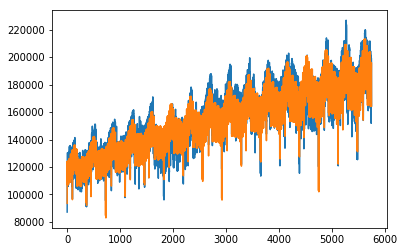

3.569724436137864


In [189]:
model = LinearRegression()
prediction=special.inv_boxcox(regresion_linear(Combinacion,general.MWh.values), lam)
plt.plot(onlyMWh.MWh.values)
plt.plot(prediction)
#plt.axis([1630,1650,120000,160000])
plt.show()
comparacion=pd.DataFrame(columns=['real','prediccion','error'])
comparacion.real=onlyMWh.MWh.values
comparacion.prediccion=prediction
comparacion.error=np.abs((comparacion.real-comparacion.prediccion)/comparacion.real)
MAPE=comparacion.error.mean()*100
print(MAPE)

### Obtener error de datos con variables dummies vs datos reales

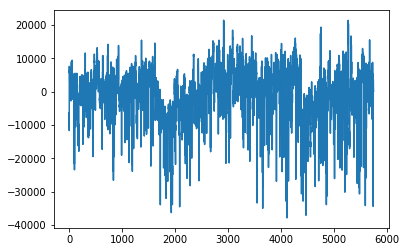

In [190]:
Tabla=pd.DataFrame(columns=['regresion','datos','resta'])
Tabla["regresion"]=prediction
Tabla["datos"]=onlyMWh.MWh.values
Tabla["resta"]=Tabla.datos-Tabla.regresion
plt.plot(Tabla.resta)
plt.show()

### Establecer las frecuencias que se debe considerar en la serie de fourier

C:\Users\Diana\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in true_divide



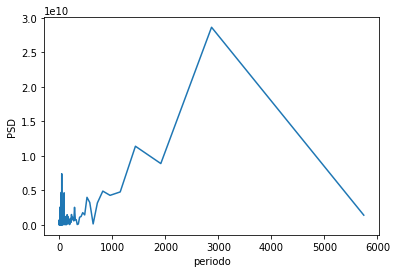

In [191]:
f, Pxx_den = signal.periodogram(Tabla.resta, 1)
plt.plot(1/f, Pxx_den)
plt.xlabel('periodo')
plt.ylabel('PSD')
plt.show()

In [192]:
top_50_periods = {}
# get indices for 3 highest Pxx values
top50_freq_indices = np.flip(np.argsort(Pxx_den), 0)[0:8]

freqs = f[top50_freq_indices]
power = Pxx_den[top50_freq_indices]
periods = 1 / np.array(freqs)
matrix=pd.DataFrame(columns=["power","periods"])
matrix.power=power
matrix.periods=periods
print(matrix)

          power      periods
0  2.861934e+10  2872.000000
1  1.139077e+10  1436.000000
2  8.884024e+09  1914.666667
3  7.413894e+09    45.587302
4  4.895075e+09   820.571429
5  4.776510e+09  1148.800000
6  4.719606e+09    36.585987
7  4.646777e+09    91.174603


### Hacer la regresión del efecto cruzado de variables dummies y senos/cosenos absolutos de frecuencia de error

In [214]:
n=-5
final=general.MWh.tail(n*-1)
sencos = pd.DataFrame()
sencos["t"]=np.arange(1,len(onlyMWh)+1)
for i  in  matrix.periods:
        sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/i)*t))
        sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/i)*t))
sencos["unos"] = 1

In [215]:
sencos_test=sencos[n:]
sencos_train=sencos[0:n]
Dum_test=Dum[n:]
Dum_train=Dum[0:n]
Combinacion=kronecker(Dum_train,sencos_train)

In [216]:
model = LinearRegression()
prediction=special.inv_boxcox(regresion_linear(Combinacion,general.MWh[0:n].values), lam)

### MAPE de la regresion

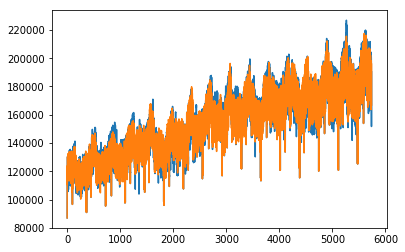

2.6327584618233915


In [217]:
plt.plot(onlyMWh.MWh[0:n].values)
plt.plot(prediction)
#plt.axis([1630,1650,120000,160000])
plt.show()
#%%obtener mape de regresión
comparacion=pd.DataFrame(columns=['real','prediccion','error'])
comparacion.real=onlyMWh.MWh[0:n].values
comparacion.prediccion=prediction
comparacion.error=np.abs((comparacion.real.values-comparacion.prediccion)/comparacion.real)
MAPE=comparacion.error.mean()*100
print(MAPE)

### Gráfica de manera dinámica

In [219]:
import plotly.graph_objs as go
from plotly.offline import plot
data1=go.Scatter(x=dates, y=onlyMWh.MWh[0:n].values,name='REAL')
data2=go.Scatter(x=dates, y=prediction,name='PREDICCIÓN')
fig=go.Figure(data = [data1,data2])
plot(fig)

'temp-plot.html'

Tabla=pd.DataFrame(columns=['regresion','datos','resta'])
Tabla["regresion"]=special.inv_boxcox(prediction, lam)
Tabla["datos"]=general.MWh[0:n].values
Tabla["error"]=Tabla.datos-Tabla.regresion
plt.plot(Tabla.error)
plt.show()

from pyramid.arima import auto_arima
stepwise_model = auto_arima(Tabla.error, start_p=1, start_q=0,
                           max_p=2, max_q=0, m=365,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

stepwise_model.fit(Tabla.error[0:-20])
future_forecast = stepwise_model.predict(n_periods=20)

future_forecast = pd.DataFrame(future_forecast, columns=[‘Prediction’])
plt.plot(future_forecast)
plt.plot(Tabla.error[-20:])

### todo para pronóstico

In [211]:
Combinaciontest=kronecker(Dum_test,sencos_test)
ynew = special.inv_boxcox(model.predict(Combinaciontest),lam)
comp_pronostico=pd.DataFrame(columns=['real','prediccion','error'])
comp_pronostico.real=special.inv_boxcox(final,lam)
comp_pronostico.prediccion=ynew
comp_pronostico.error=np.abs((comp_pronostico.real-ynew)/comp_pronostico.real)
MAPE=comp_pronostico.error.mean()*100
print(MAPE)

0.7450460464574182


In [212]:
for x in range (0,-n-1):
    if comp_pronostico.error.iloc[x] > .1:
        print (comp_pronostico.iloc[x:x+1])

In [213]:
comp_pronostico

,real,prediccion,error
fecha,,,
2019-09-18,199330.987,196717.309397,0.013112
2019-09-19,197681.325,198811.697677,0.005718
2019-09-20,195693.814,195890.356155,0.001004
2019-09-21,185969.621,187445.282699,0.007935
2019-09-22,164464.339,166023.888668,0.009483
